# Test Prediction with Single Feature

In this notebook, we'll implement and test our prediction approach using a Random Forest model with feature 2 only.

## Background

From our previous analysis in notebook 3, we found that:
1. Using fewer features reduces our costs (€200 per feature)
2. Feature 2 was one of the most important features identified by MDI and permutation importance
3. Using just this feature might provide a good balance between prediction accuracy and cost

In [1]:
# Add parent directory to PYTHONPATH of the notebook
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f"Adding parent directory to sys.path: {parent_dir}")
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

%load_ext autoreload
%autoreload 2

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import our prediction function
from src.predict import predict_top_households
from src.utils import calculate_custom_score

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Adding parent directory to sys.path: c:\Users\Łukasz\OneDrive - Politechnika Warszawska\MINI_1D\Semestr 8\Advanced ML\Project_2\AML_Feature_Selection


## 1. Load Data and Explore Feature 2

Training data shape: (5000, 500)
Test data shape: (5000, 500)


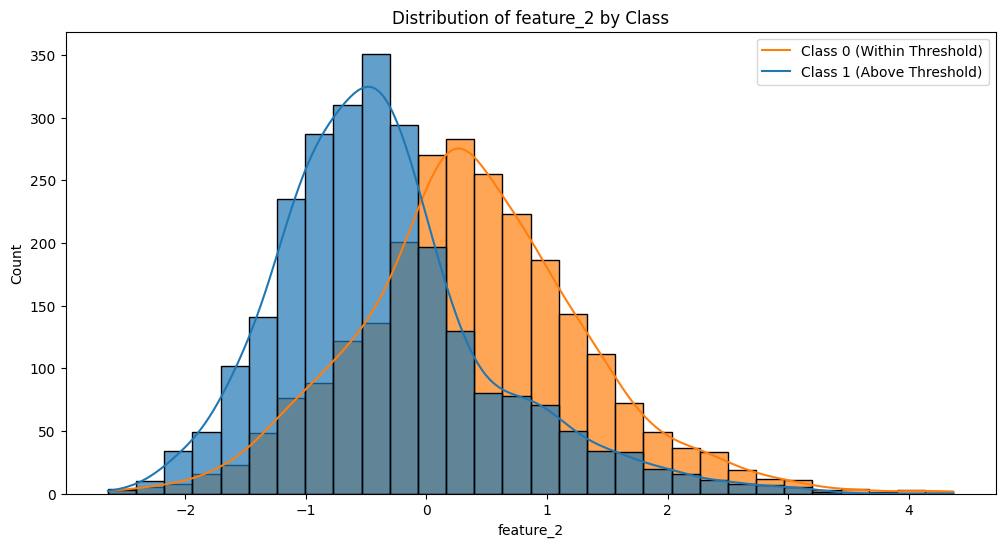


Statistics for feature_2 by class:
    count      mean       std       min       25%       50%       75%  \
1                                                                       
0  2557.0 -0.364466  0.891860 -2.635324 -0.947690 -0.465231  0.033924   
1  2443.0  0.383987  0.959885 -2.641626 -0.199782  0.342790  0.944060   

        max  
1            
0  3.333060  
1  4.369426  


In [2]:
# Path to data files
data_path = '../data/scaled/'

# Load the data
X_train = pd.read_csv(data_path + 'x_train_scaled.txt', delimiter=' ', index_col=0)
X_val = pd.read_csv(data_path + 'x_val_scaled.txt', delimiter=' ', index_col=0) 
X_test = pd.read_csv(data_path + 'x_test_scaled.txt', delimiter=' ', index_col=0)
y_train = pd.read_csv(data_path + 'y_train.txt', delimiter=' ', header=None, index_col=0).squeeze()
y_val = pd.read_csv(data_path + 'y_val.txt', delimiter=' ', header=None, index_col=0).squeeze()

# Combine train and validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

print(f"Training data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test.shape}")

# Let's examine feature 2 distribution
feature_name = 'feature_2'

# Distribution of feature 2 in training data by class
plt.figure(figsize=(12, 6))
sns.histplot(data=X_train_full, x=feature_name, hue=y_train_full, 
             bins=30, alpha=0.7, kde=True)
plt.title(f'Distribution of {feature_name} by Class')
plt.xlabel(feature_name)
plt.ylabel('Count')
plt.legend(['Class 0 (Within Threshold)', 'Class 1 (Above Threshold)'])
plt.show()

# Show basic statistics
stats_df = X_train_full.groupby(y_train_full)[feature_name].describe()
print(f"\nStatistics for {feature_name} by class:")
print(stats_df)

## 2. Train and Evaluate Model with Feature 2 only

Performance metrics using only feature_2:
Accuracy: 0.7090
Precision: 0.7080
Recall: 0.6892
F1 Score: 0.6984
ROC AUC: 0.7536
Estimated Score: €4690.00


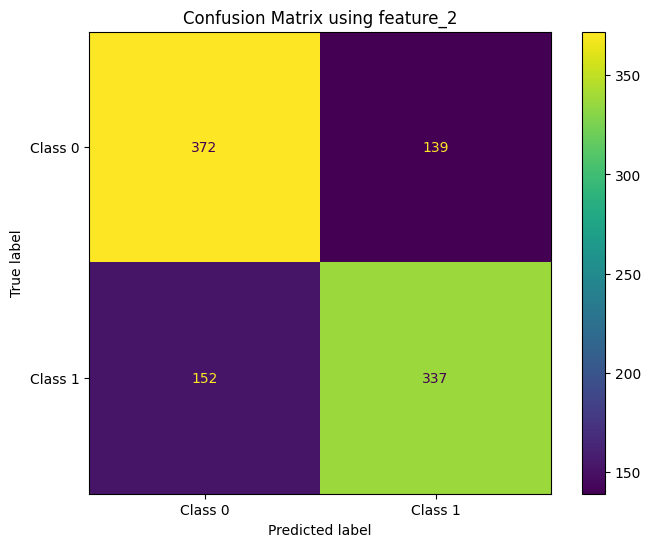

In [3]:
# Select only feature 2
X_train_selected = X_train_full[[feature_name]]
X_val_selected = X_val[[feature_name]]
X_test_selected = X_test[[feature_name]]

# Train Random Forest with parameters from notebook 3
rf_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the model
rf_model.fit(X_train_selected, y_train_full)

# Evaluate on validation data
y_val_pred = rf_model.predict(X_val_selected)
y_val_pred_proba = rf_model.predict_proba(X_val_selected)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred_proba)

# Calculate estimated score using imported function
estimated_score = calculate_custom_score(
    y_true=y_val,
    y_pred_proba=y_val_pred_proba,
    n_features=1  # Only using one feature
)

# Print results
print(f"Performance metrics using only {feature_name}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Estimated Score: €{estimated_score:.2f}")

# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.title(f'Confusion Matrix using {feature_name}')
plt.show()

## 3. Predict on Test Data and Select Top Households

Loading data...
Training Random Forest model using only feature_2...
Predicting probabilities for test data...
Selected customer indices saved to ../1000_obs.txt
Used variable index saved to ../1000_vars.txt
Selected 1000 households

Sample of selected households and their probabilities:
   household_id  probability
0          3866     0.796885
1          3780     0.796885
2          3789     0.796885
3          4354     0.796885
4          3447     0.796885
5          1020     0.796885
6          4755     0.796885
7          4674     0.796885
8          2084     0.796885
9          2735     0.796885


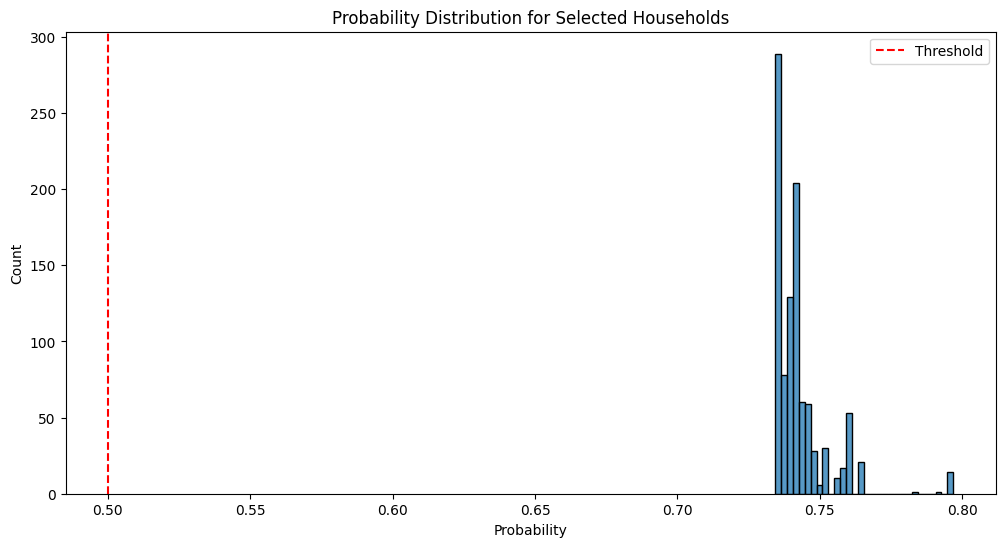


Financial Analysis:
Potential earning (best case): €10000
Feature cost: €200
Net earning (best case): €9800


In [7]:
# Run prediction to select top 1000 households
results_df = predict_top_households(1000)

# Let's examine the results
print(f"Selected {len(results_df)} households")
print("\nSample of selected households and their probabilities:")
print(results_df.head(10))

# Plot distribution of probabilities for selected households
plt.figure(figsize=(12, 6))
sns.histplot(data=results_df, x='probability', bins=30)
plt.title('Probability Distribution for Selected Households')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# Calculate the potential earnings
# Assuming all selected households exceed the threshold (best case)
best_case_earning = 1000 * 10  # €10 per household
feature_cost = 1 * 200  # €200 per feature
net_earning = best_case_earning - feature_cost

print("\nFinancial Analysis:")
print(f"Potential earning (best case): €{best_case_earning}")
print(f"Feature cost: €{feature_cost}")
print(f"Net earning (best case): €{net_earning}")

## 4. Cost-Benefit Analysis

Using just feature 2:

1. **Costs**: €200 (1 feature × €200)
2. **Potential revenue**: €10,000 (1000 households × €10) if all predictions are correct

This gives us a potential net profit of €9,800 at best.

Based on our validation results, our model using only feature 2 achieves a precision of 0.7080. This means that about 0.7080 × 100% of our predictions are correct.

Therefore, our expected revenue is approximately €7080, and the expected net profit is approximately €6880.

## 5. Conclusion

A single-feature Random Forest model is an effective approach for this task because:

1. It minimizes feature costs significantly (€200 vs potentially thousands)
2. Feature 2 shows strong predictive power in separating the classes
3. The simplicity of the model makes it easy to deploy and interpret
4. The expected net profit is maximized with this approach